In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#import xgboost as xgb
#import lightgbm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
#from lightgbm import LGBMClassifier
import gc

In [2]:
!pip install imbalanced-learn

In [3]:
!pip install delayed

In [1]:
import imblearn
print(imblearn.__version__)

0.8.0


In [4]:

# define resampling
over = ...
under = ...
# define pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under)])
# define resampling
over = ...
under = ...
# define pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under)])

NameError: name 'Pipeline' is not defined

In [5]:
transaction = pd.read_json('transactions/transactions.txt', lines=True)

In [8]:
transaction.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [6]:
transaction.shape

(786363, 29)

In [7]:
print("number of rows:",transaction.shape[0])
print("number of columns:",transaction.shape[1])


number of rows: 786363
number of columns: 29


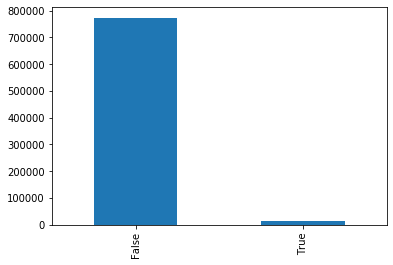

In [12]:
#print('Not fraud cases :',len(transaction[transaction['isFraud']==1]))
#print('Not fraud cases :',len(transaction[transaction['isFraud']==0]))
transaction['isFraud'].value_counts().plot(kind='bar')

#### data types

In [14]:
print('Data types of columns')
print(transaction.dtypes)

Data types of columns
accountNumber                 int64
customerId                    int64
creditLimit                   int64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                       int64
enteredCVV                    int64
cardLast4Digits               int64
transactionType              object
echoBuffer                   object
currentBalance              float64
merchantCity                 object
merchantState                object
merchantZip                  object
cardPresent                    bool
posOnPremises                object
recurringAuthInd             object
expira

check for null values

In [15]:
print('checking for null values')
transaction.isnull().sum()

checking for null values


accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [16]:
print("Null Values as empty string")
str_columns = transaction.select_dtypes(include=['object']).columns
for col in str_columns:
    null_value = (transaction[col].values == '').sum()
    print(col,"-",null_value)

Null Values as empty string
transactionDateTime - 0
merchantName - 0
acqCountry - 4562
merchantCountryCode - 724
posEntryMode - 4054
posConditionCode - 409
merchantCategoryCode - 0
currentExpDate - 0
accountOpenDate - 0
dateOfLastAddressChange - 0
transactionType - 698
echoBuffer - 786363
merchantCity - 786363
merchantState - 786363
merchantZip - 786363
posOnPremises - 786363
recurringAuthInd - 786363


In [17]:
#numerical_cols = transaction.select_dtypes(include=['int64','float64']).columns
numerical_cols= transaction.select_dtypes(include=['int64','float64']).columns #select only columns with numeric type in the df
#numerical_cols.head
numerical_cols

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionAmount', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'currentBalance'],
      dtype='object')

In [18]:
transaction[numerical_cols].describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,4508.739089
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,6457.442068
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,0.000000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,689.910000
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,2451.760000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,5291.095000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,47498.810000


check for categorical values

In [19]:
str_columns = transaction.select_dtypes(include=['object']).columns #include only string type in the dataframe
print('No. of unique values in each columns')
for col in str_columns:
    unique_col = transaction[col].nunique()
    print(col, "-", unique_col)

No. of unique values in each columns
transactionDateTime - 776637
merchantName - 2490
acqCountry - 5
merchantCountryCode - 5
posEntryMode - 6
posConditionCode - 4
merchantCategoryCode - 19
currentExpDate - 165
accountOpenDate - 1820
dateOfLastAddressChange - 2184
transactionType - 4
echoBuffer - 1
merchantCity - 1
merchantState - 1
merchantZip - 1
posOnPremises - 1
recurringAuthInd - 1


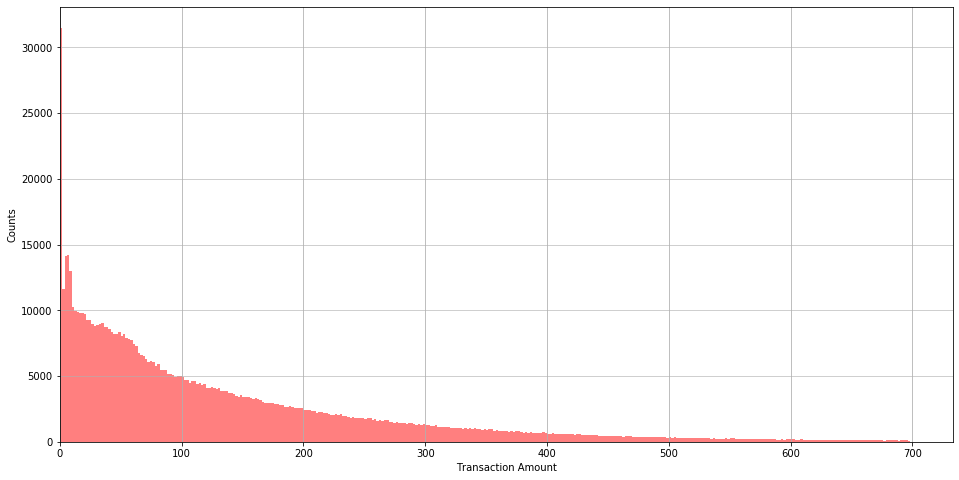

In [20]:
plt.figure(figsize=[16,8]);
binwidth=2
transaction['transactionAmount'].plot.hist(grid=True,color='r', alpha=0.5, label='x',bins=(range(0,700, binwidth)))
plt.xlim(xmin=0)
plt.ylim(ymin=0)
#plt.xlabel('Average tweet length (Number of char)')
plt.xlabel('Transaction Amount')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [21]:
transaction['transactionType'].unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', ''], dtype=object)

In [22]:
transaction.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [23]:
transaction_purchase_zero = transaction_purchase[transaction_purchase['transactionAmount'] ==0]
print("total length:",len(transaction_purchase_zero))
transaction_purchase_zero.groupby(by='merchantCategoryCode')['customerId'].count().sort_values(ascending=False).reset_index()

NameError: name 'transaction_purchase' is not defined

In [ ]:
transaction_purchase_zero.groupby(by='merchantName')['customerId'].count().sort_values(ascending=False).reset_index()

In [24]:
transaction_purchase_below_fifty = transaction_purchase[transaction_purchase['transactionAmount'] <50]
transaction_purchase_below_fifty.groupby(by=['merchantCategoryCode','merchantName'])['customerId'].count().sort_values(ascending=False).reset_index()

NameError: name 'transaction_purchase' is not defined

In [25]:
transaction_purchase_3_12 = transaction_purchase[(transaction_purchase['transactionAmount'] >=3) & (transaction_purchase['transactionAmount']<=12)]
transaction_purchase_3_12.groupby(['merchantCategoryCode','merchantName'])['customerId'].count().sort_values(ascending=False).reset_index(name='count')

NameError: name 'transaction_purchase' is not defined

In [26]:
transaction[transaction['transactionType']=="ADDRESS_VERIFICATION"]['transactionAmount'].sum()

0.0

transaction type=Purchase

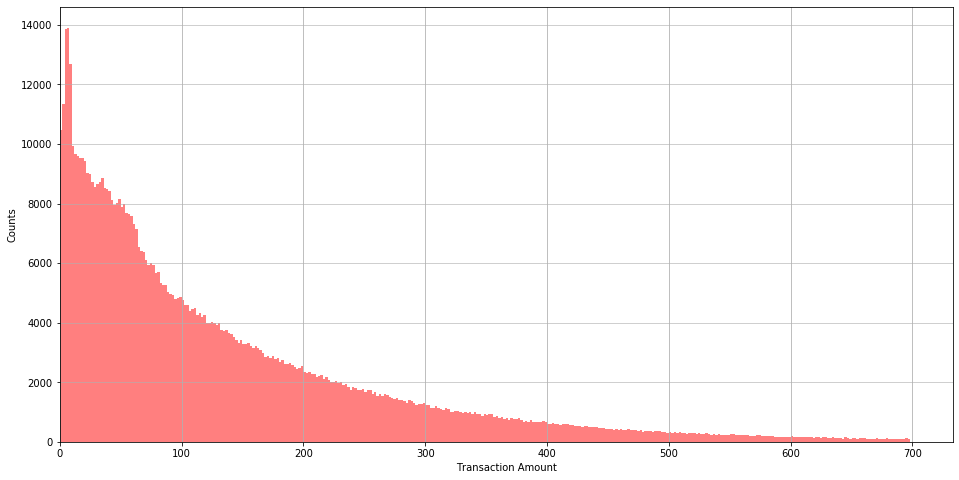

In [21]:
transaction_purchase = transaction[transaction['transactionType'] == 'PURCHASE']
plt.figure(figsize=[16,8]);
binwidth=2
transaction_purchase['transactionAmount'].plot.hist(grid=True,color='r', alpha=0.5, label='x',bins=(range(0,700, binwidth)))
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Transaction Amount')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
address verification

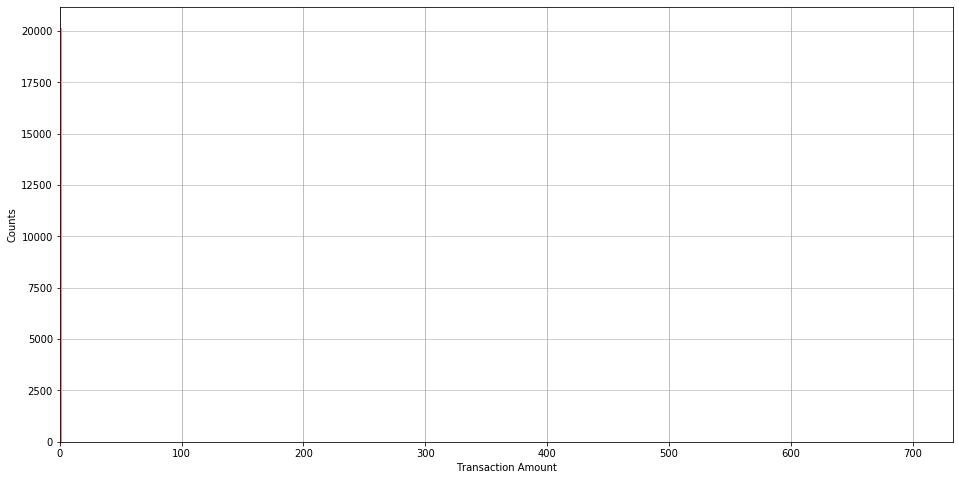

In [26]:
transaction_address = transaction[transaction['transactionType'] == 'ADDRESS_VERIFICATION']
plt.figure(figsize=[16,8]);
binwidth=2
transaction_address['transactionAmount'].plot.hist(grid=True,color='r', alpha=0.5, label='x',bins=(range(0,700, binwidth)))
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Transaction Amount')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.show()

Reversal

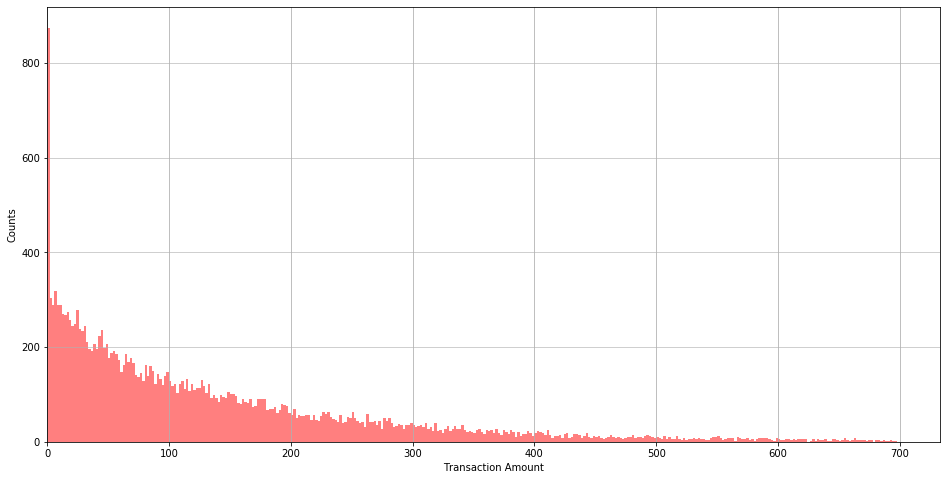

In [27]:
transaction_address = transaction[transaction['transactionType'] == 'REVERSAL']
plt.figure(figsize=[16,8]);
binwidth=2
transaction_address['transactionAmount'].plot.hist(grid=True,color='r', alpha=0.5, label='x',bins=(range(0,700, binwidth)))
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Transaction Amount')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
transaction[transaction['transactionType'] == 'PURCHASE']['']

#### Shape of the data set

In [ ]:
print("No. of rows in the dataset", transaction.shape[0])
print("No. of columns in the dataset", transaction.shape[1])

#### Data types of the columns

In [ ]:
print('Data types of columns')
print(transaction.dtypes)

#### Null Values

In [ ]:
print('Null values in the dataset')
transaction.isnull().sum()

#### The character datatypes has empty string not NA or NAN. Lets detect the count of empty string

In [ ]:
print("Null Values as empty string")
str_columns = transaction.select_dtypes(include=['object']).columns
for col in str_columns:
    null_value = (transaction[col].values == '').sum()
    print(col,"-",null_value)

#### All the values of the columns echoBuffer,merchantCity,  merchantState, merchantZip, posOnPremises, recurringAuthInd are empty. We can drop these columns

In [ ]:
transaction.drop(columns=['echoBuffer', 'merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'], inplace = True)


In [ ]:
transaction.shape

#### Let's explore each of the columns

##### Numerical columns
##### Account number and customerid seems same, lets check how many of rows are different


In [ ]:
diff = (transaction['accountNumber']  != transaction['customerId']).sum()
print("No. of different account number and customerid", diff)

##### We can drop any one of them columns as all of the data are same

In [ ]:
transaction.drop(['accountNumber'],inplace = True, axis = 1)

In [ ]:
transaction.shape

In [ ]:
transaction.select_dtypes(include=['int64','float64']).columns

In [ ]:
transaction[['creditLimit','availableMoney','transactionAmount','cardCVV','enteredCVV','cardLast4Digits','currentBalance']].describe()

#### Categorical columns

In [ ]:
str_columns = transaction.select_dtypes(include=['object']).columns
print('No. of unique values in each columns')
for col in str_columns:
    unique_col = transaction[col].nunique()
    print(col, "-", unique_col)

In [ ]:
transaction['merchantName'].nunique()

In [ ]:
transaction.groupby('merchantName')['customerId'].count().sort_values(ascending=False).reset_index(name='count')

In [ ]:
transaction.groupby('acqCountry')['customerId'].count().sort_values(ascending=False).reset_index(name='count')

In [ ]:
transaction.groupby('merchantCountryCode')['customerId'].count().sort_values(ascending=False).reset_index(name='count')


In [ ]:
transaction.groupby('posEntryMode')['customerId'].count().sort_values(ascending=False).reset_index(name='count')

In [ ]:
transaction.groupby('posConditionCode')['customerId'].count().sort_values(ascending=False).reset_index(name='count')

In [ ]:
transaction.groupby('merchantCategoryCode')['customerId'].count().sort_values(ascending=False).reset_index(name='count')

In [ ]:
transaction.groupby('transactionType')['customerId'].count().sort_values(ascending=False).reset_index(name='count')

In [ ]:
transaction.groupby('isFraud')['customerId'].count()

In [ ]:
transaction.groupby('expirationDateKeyInMatch')['customerId'].count()

In [ ]:
### expirationDateKeyInMatch does not seems to have no imoact

In [ ]:
s = transaction[transaction['expirationDateKeyInMatch'] == True]
s.groupby('isFraud')['customerId'].count()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[16,8]);
plt.hist(transaction['transactionAmount'], density=False, bins=50)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Transaction Amount');

In [ ]:
transaction_purchase = transaction[transaction['transactionType'] == 'PURCHASE']
plt.figure(figsize=[16,8]);
plt.hist(transaction_purchase['transactionAmount'], density=False, bins=50)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Transaction Amount');

In [ ]:
transaction_purchase[transaction_purchase['transactionAmount'] == 0].head(20)

In [ ]:
transaction_purchase = transaction[transaction['transactionType'] == 'ADDRESS_VERIFICATION']
plt.figure(figsize=[16,8]);
plt.hist(transaction_purchase['transactionAmount'], density=False, bins=50)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Transaction Amount');

In [ ]:
reversal = transaction[transaction['transactionType'] == 'REVERSAL']
reversal.groupby('customerId')['acqCountry'].count().sort_values(ascending=False)


In [36]:
transaction[transaction['customerId'] == 724518977].head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
751000,724518977,20000,20000.00,2016-01-01T00:29:42,74.09,apple.com,US,US,09,01,online_retail,02/2027,2014-12-04,2014-12-04,339,339,5846,PURCHASE,0.00,False,False,False
751001,724518977,20000,19925.91,2016-01-01T01:18:26,200.66,amazon.com,US,US,02,01,online_retail,06/2029,2014-12-04,2014-12-04,339,339,5846,PURCHASE,74.09,False,False,False
751002,724518977,20000,19725.25,2016-01-01T03:09:42,243.42,ebay.com,US,US,02,01,online_retail,03/2023,2014-12-04,2014-12-04,289,289,1377,PURCHASE,274.75,False,False,False
751003,724518977,20000,19481.83,2016-01-01T04:03:15,0.00,alibaba.com,US,US,02,01,online_retail,09/2028,2014-12-04,2014-12-04,339,339,5846,ADDRESS_VERIFICATION,518.17,False,False,False
751004,724518977,20000,19481.83,2016-01-01T04:05:43,22.65,walmart.com,US,US,02,01,online_retail,05/2032,2014-12-04,2014-12-04,339,339,5846,PURCHASE,518.17,False,False,False


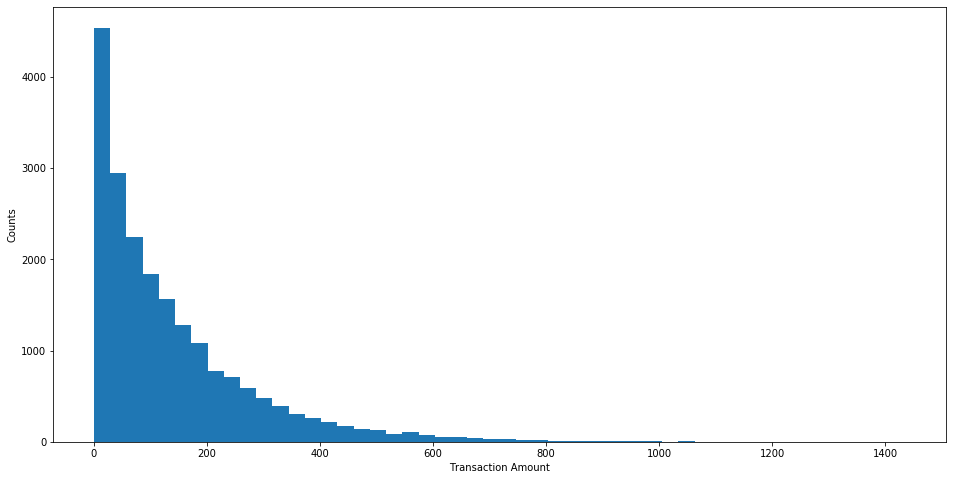

In [37]:
transaction_purchase = transaction[transaction['transactionType'] == 'REVERSAL']
plt.figure(figsize=[16,8]);
plt.hist(transaction_purchase['transactionAmount'], density=False, bins=50)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Transaction Amount');

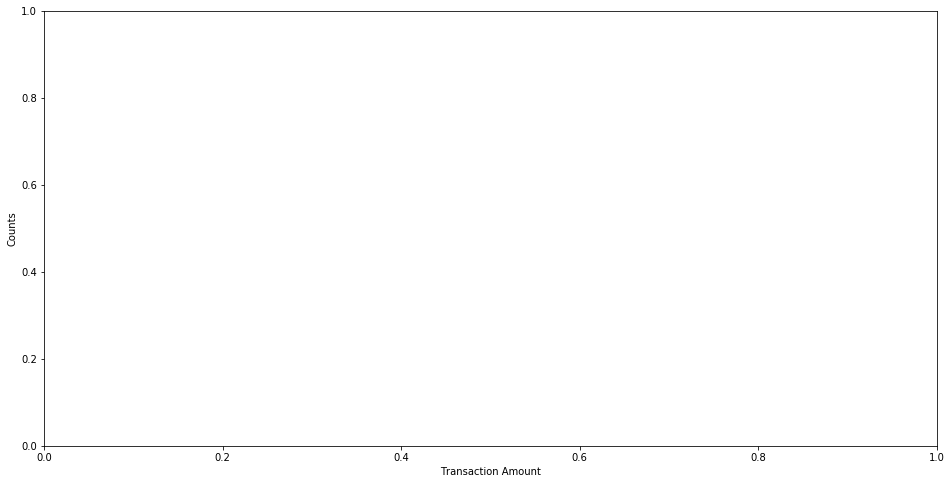

In [27]:
transaction_purchase = transaction[transaction['transactionType'] == 'PURCHASE']
plt.figure(figsize=[16,8]);
#plt.hist(transaction2['transactionAmount'], density=False, bins=50)  # density=False would make counts
plt.ylabel('Counts')
plt.xlabel('Transaction Amount');

In [28]:
t = transaction[transaction['transactionType'] == 'ADDRESS_VERIFICATION']
t['transactionAmount'].sum()

0.0

In [29]:
transaction[transaction['customerId'] == 380680241].head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
240190,380680241,380680241,5000,5000.00,2016-01-01T00:06:17,96.68,Fresh Flowers,US,US,05,...,,0.00,,,,False,,,False,False
240191,380680241,380680241,5000,4903.32,2016-01-01T00:14:21,339.52,Next Day eCards,US,US,02,...,,96.68,,,,False,,,False,False
240192,380680241,380680241,5000,4563.80,2016-01-01T00:16:58,33.40,Blue Mountain Online Services,US,US,05,...,,436.20,,,,False,,,False,False
240193,380680241,380680241,5000,4530.40,2016-01-01T00:23:10,168.80,Blue Mountain Online Services,US,US,02,...,,469.60,,,,False,,,False,False
240194,380680241,380680241,5000,4361.60,2016-01-01T00:25:04,259.26,Blue Mountain Online Services,US,US,02,...,,638.40,,,,False,,,False,False


In [30]:
#Q3 Reversal Transactions

total_count=transaction[transaction['transactionType']=='REVERSAL']['customerId'].count()
total_sum=transaction[transaction['transactionType']=='REVERSAL']['customerId'].sum()
print("The total number of Reversed transactions is {}".format(total_count))
print("The total transaction amount of Reversed transactions is {:.2f}".format(total_sum))

The total number of Reversed transactions is 20303
The total transaction amount of Reversed transactions is 10879795834486.00


In [31]:
# Converting transaction time in time format
def convert_str_to_date(date_var):
    return(datetime.strptime(date_var["transactionDateTime"], '%Y-%m-%dT%H:%M:%S'))
transaction["transactionDateTime_date"]=transaction.apply(convert_str_to_date,axis=1)
transaction.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,transactionDateTime_date
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,0.0,,,,False,,,False,False,2016-08-13 14:27:32
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,0.0,,,,True,,,False,False,2016-10-11 05:05:54
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,0.0,,,,False,,,False,False,2016-11-08 09:18:39
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,0.0,,,,False,,,False,False,2016-12-10 02:14:50
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,0.0,,,,True,,,False,False,2016-03-24 21:04:46


In [32]:
transaction = transaction.sort_values(by=['customerId','transactionDateTime' ])
transaction.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,transactionDateTime_date
541900,100088067,100088067,50000,50000.00,2016-01-12T00:59:52,205.13,EZ Putt Putt #982199,US,US,02,...,0.00,,,,True,,,False,False,2016-01-12 00:59:52
541901,100088067,100088067,50000,49794.87,2016-01-12T19:49:41,46.43,Dinosaur Sandwitch Bar #303701,US,US,05,...,205.13,,,,True,,,False,False,2016-01-12 19:49:41
541902,100088067,100088067,50000,49748.44,2016-01-17T15:41:46,378.67,Mobile eCards,US,US,05,...,251.56,,,,False,,,False,False,2016-01-17 15:41:46
541903,100088067,100088067,50000,50000.00,2016-02-02T19:57:18,66.07,EZ Putt Putt #40513,US,US,02,...,0.00,,,,True,,,False,False,2016-02-02 19:57:18
541904,100088067,100088067,50000,49933.93,2016-02-03T04:48:54,141.60,34th BBQ #412895,US,US,09,...,66.07,,,,True,,,False,False,2016-02-03 04:48:54


In [33]:
#Q3
#tranction data to check if the two transaction amounts are same  
transaction['Match'] = transaction.transactionAmount.eq(transaction.transactionAmount.shift())
transaction.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,transactionDateTime_date,Match
541900,100088067,100088067,50000,50000.00,2016-01-12T00:59:52,205.13,EZ Putt Putt #982199,US,US,02,...,,,,True,,,False,False,2016-01-12 00:59:52,False
541901,100088067,100088067,50000,49794.87,2016-01-12T19:49:41,46.43,Dinosaur Sandwitch Bar #303701,US,US,05,...,,,,True,,,False,False,2016-01-12 19:49:41,False
541902,100088067,100088067,50000,49748.44,2016-01-17T15:41:46,378.67,Mobile eCards,US,US,05,...,,,,False,,,False,False,2016-01-17 15:41:46,False
541903,100088067,100088067,50000,50000.00,2016-02-02T19:57:18,66.07,EZ Putt Putt #40513,US,US,02,...,,,,True,,,False,False,2016-02-02 19:57:18,False
541904,100088067,100088067,50000,49933.93,2016-02-03T04:48:54,141.60,34th BBQ #412895,US,US,09,...,,,,True,,,False,False,2016-02-03 04:48:54,False


In [34]:
transaction["Time_Diff"]=transaction["transactionDateTime_date"].diff()
transaction.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,transactionDateTime_date,Match,Time_Diff
541900,100088067,100088067,50000,50000.00,2016-01-12T00:59:52,205.13,EZ Putt Putt #982199,US,US,02,...,,,True,,,False,False,2016-01-12 00:59:52,False,NaT
541901,100088067,100088067,50000,49794.87,2016-01-12T19:49:41,46.43,Dinosaur Sandwitch Bar #303701,US,US,05,...,,,True,,,False,False,2016-01-12 19:49:41,False,0 days 18:49:49
541902,100088067,100088067,50000,49748.44,2016-01-17T15:41:46,378.67,Mobile eCards,US,US,05,...,,,False,,,False,False,2016-01-17 15:41:46,False,4 days 19:52:05
541903,100088067,100088067,50000,50000.00,2016-02-02T19:57:18,66.07,EZ Putt Putt #40513,US,US,02,...,,,True,,,False,False,2016-02-02 19:57:18,False,16 days 04:15:32
541904,100088067,100088067,50000,49933.93,2016-02-03T04:48:54,141.60,34th BBQ #412895,US,US,09,...,,,True,,,False,False,2016-02-03 04:48:54,False,0 days 08:51:36


In [35]:
#find the differences in the two successive dates 
transaction["Time_Diff"]=transaction["transactionDateTime_date"].diff()

C:\Users\Gopalkrishna .N\Downloads\New_folder\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


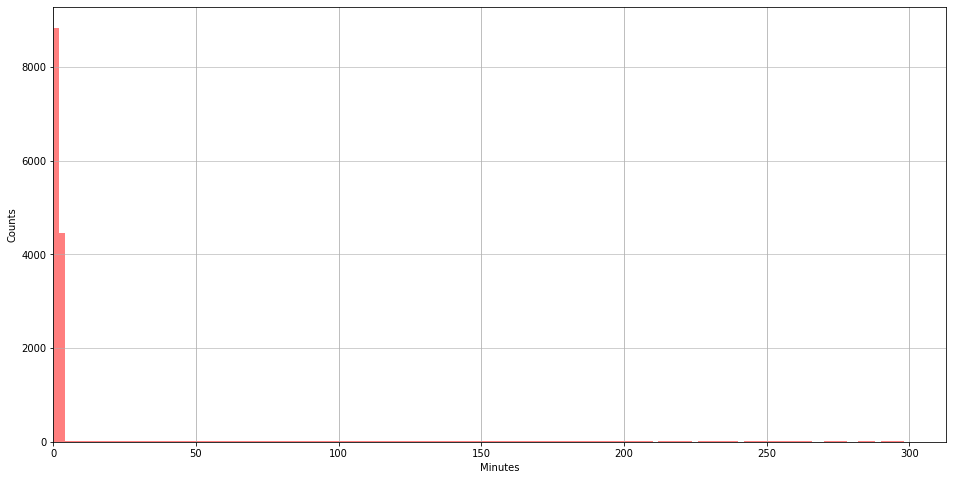

In [36]:
# To find the threshold of time difference to consider it as multi swipe transaction lets draw the histogram and kde plot
transaction_match =transaction[transaction["Match"]==True]
transaction_match["minute_range"]=transaction_match.apply(lambda y:int(y["Time_Diff"].seconds/60),axis=1)
plt.figure(figsize=[16,8]);
binwidth=2
transaction_match["minute_range"].plot.hist(grid=True,color='r', alpha=0.5, label='x',bins=(range(0,300, binwidth))) # histogram 
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Minutes')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.show()

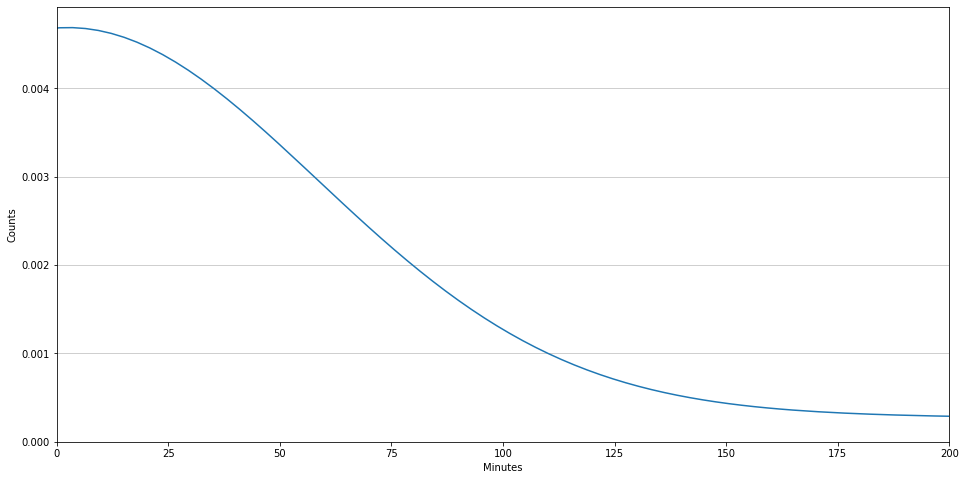

In [37]:
plt.figure(figsize=[16,8]);
binwidth=2
#transaction_match["minute_range"].plot.hist(grid=True,color='r', alpha=0.5, label='x',bins=(range(0,300, binwidth))) # histogram 
transaction_match["minute_range"].plot.kde() #kde plot
plt.xlim(xmin=0)
plt.xlim(xmax=200)
plt.ylim(ymin=0)
plt.xlabel('Minutes')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
plt.show()
#the density plot shows that many of the transactions are below 4 minutes

In [38]:
print("Median of difference in time is",transaction_match["minute_range"].median())
print("64 percentile of difference in time",transaction_match["minute_range"].quantile(0.64))
print("65 percentile of difference in time",transaction_match["minute_range"].quantile(0.65)) 

Median of difference in time is 2.0
64 percentile of difference in time 2.0
65 percentile of difference in time 26.0


In [39]:
#find those transactions which are not of the reversal type and the time difference is below 4 minutes  and the transaction amounts are a match 
transaction_match =transaction[transaction["Match"]==True]

import datetime
def update(x):
    if x["Time_Diff"]<=datetime.timedelta(minutes=4) and x["transactionType"]!="REVERSAL":
        return True
    #if x[(x["Time_Diff"]<=datetime.timedelta(minutes=4)) & (x["transactionType"]!="REVERSAL")]:
    #    return True
    return False
transaction_match["Small_Time_diff"]=transaction_match.apply(update,axis=1)
transaction_match.head()

C:\Users\Gopalkrishna .N\Downloads\New_folder\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,transactionDateTime_date,Match,Time_Diff,Small_Time_diff
541956,100088067,100088067,50000,49275.09,2016-10-16T18:01:02,411.35,Fresh Flowers,US,US,02,...,,False,,,False,False,2016-10-16 18:01:02,True,0 days 00:00:02,True
541964,100088067,100088067,50000,49811.88,2016-11-20T08:00:04,22.32,AMC #79863,US,US,09,...,,True,,,False,False,2016-11-20 08:00:04,True,0 days 00:02:59,False
225230,100108752,100108752,5000,4890.09,2016-06-19T13:58:42,45.35,Shell Gas #494785,US,US,05,...,,True,,,False,False,2016-06-19 13:58:42,True,14 days 10:14:06,False
225231,100108752,100108752,5000,4869.74,2016-07-03T07:30:00,45.35,Shell Gas #494785,US,US,05,...,,True,,,False,False,2016-07-03 07:30:00,True,13 days 17:31:18,False
225232,100108752,100108752,5000,4824.39,2016-07-17T21:53:06,45.35,Shell Gas #494785,US,US,05,...,,True,,,False,False,2016-07-17 21:53:06,True,14 days 14:23:06,False


In [40]:
#find those transactions which are not of the reversal type and the time difference is below 4 minutes  and the transaction amounts are a match 

import datetime
a=transaction[transaction["Match"]==True]
def update(x):
    if x["Time_Diff"]<=datetime.timedelta(minutes=4) and x["transactionType"]!="REVERSAL":
        return True
    return False
a["Small_Time_diff"]=a.apply(update,axis=1)


C:\Users\Gopalkrishna .N\Downloads\New_folder\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [41]:
#multi-swipe transactions
total_count=transaction_match[transaction_match["Small_Time_diff"]==True]['customerId'].count()
total_sum=transaction_match[transaction_match["Small_Time_diff"]==True]['transactionAmount'].sum()
print("The total number of multi swipe transactions is {}".format(total_count))
print("The total transaction amount of multi swipe transactions is {:.2f}".format(total_sum))

The total number of multi swipe transactions is 7620
The total transaction amount of multi swipe transactions is 1091969.89


Modeling

In [42]:
#multi-swipe transactions
total_count=a[a["Small_Time_diff"]==True]['customerId'].count()
total_sum=a[a["Small_Time_diff"]==True]['transactionAmount'].sum()
print("The total number of multi swipe transactions is {}".format(total_count))
print("The total transaction amount of multi swipe transactions is {:.2f}".format(total_sum))

The total number of multi swipe transactions is 7620
The total transaction amount of multi swipe transactions is 1091969.89


#### Feature Engineering Column for difference between entered cvv and card cvv

In [43]:
#differnet entered cvv and card cvv category 
transaction_copy=transaction
transaction_copy['CvvMatch']=transaction_copy.apply(lambda x:1 if x['cardCVV']==x['enteredCVV'] else 0,axis=1)
transaction_copy.drop(columns=['cardCVV','enteredCVV'],axis=1,inplace=True)

In [44]:
transaction_copy.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,transactionDateTime_date,Match,Time_Diff,CvvMatch
541900,100088067,100088067,50000,50000.00,2016-01-12T00:59:52,205.13,EZ Putt Putt #982199,US,US,02,...,,True,,,False,False,2016-01-12 00:59:52,False,NaT,1
541901,100088067,100088067,50000,49794.87,2016-01-12T19:49:41,46.43,Dinosaur Sandwitch Bar #303701,US,US,05,...,,True,,,False,False,2016-01-12 19:49:41,False,0 days 18:49:49,1
541902,100088067,100088067,50000,49748.44,2016-01-17T15:41:46,378.67,Mobile eCards,US,US,05,...,,False,,,False,False,2016-01-17 15:41:46,False,4 days 19:52:05,1
541903,100088067,100088067,50000,50000.00,2016-02-02T19:57:18,66.07,EZ Putt Putt #40513,US,US,02,...,,True,,,False,False,2016-02-02 19:57:18,False,16 days 04:15:32,1
541904,100088067,100088067,50000,49933.93,2016-02-03T04:48:54,141.60,34th BBQ #412895,US,US,09,...,,True,,,False,False,2016-02-03 04:48:54,False,0 days 08:51:36,1


In [45]:
#column not required
transaction_copy.drop(columns=['transactionDateTime'],axis=1,inplace=True)

#### Feature engineering 2 -- adding year, month , day and hour column

In [46]:
#date conversion
def date_convertion(x):
    return (x.year,x.month,x.day,x.hour)

transaction_copy['Year'], transaction_copy['Month'], transaction_copy['Day'], transaction_copy['Hour'] = zip(*transaction_copy['transactionDateTime_date'].map(date_convertion))

In [47]:
transaction_copy.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,expirationDateKeyInMatch,isFraud,transactionDateTime_date,Match,Time_Diff,CvvMatch,Year,Month,Day,Hour
541900,100088067,100088067,50000,50000.00,205.13,EZ Putt Putt #982199,US,US,02,01,...,False,False,2016-01-12 00:59:52,False,NaT,1,2016,1,12,0
541901,100088067,100088067,50000,49794.87,46.43,Dinosaur Sandwitch Bar #303701,US,US,05,01,...,False,False,2016-01-12 19:49:41,False,0 days 18:49:49,1,2016,1,12,19
541902,100088067,100088067,50000,49748.44,378.67,Mobile eCards,US,US,05,01,...,False,False,2016-01-17 15:41:46,False,4 days 19:52:05,1,2016,1,17,15
541903,100088067,100088067,50000,50000.00,66.07,EZ Putt Putt #40513,US,US,02,01,...,False,False,2016-02-02 19:57:18,False,16 days 04:15:32,1,2016,2,2,19
541904,100088067,100088067,50000,49933.93,141.60,34th BBQ #412895,US,US,09,08,...,False,False,2016-02-03 04:48:54,False,0 days 08:51:36,1,2016,2,3,4


In [48]:
transaction_copy.shape

(786363, 34)

In [49]:
Fraud_transaction=transaction_copy[transaction_copy['isFraud']==True]
Fraud_transaction.head()
Non_Fraud_transaction=transaction_copy[transaction_copy['isFraud']==False]
Non_Fraud_transaction.head()
Non_Fraud_transaction.shape

(773946, 34)

In [50]:
transaction_copy['Hour'].unique()

array([ 0, 19, 15,  4,  6, 18, 23, 20,  1, 21,  7, 16, 12,  9, 22,  2, 10,
        3, 14,  8, 11, 13,  5, 17])

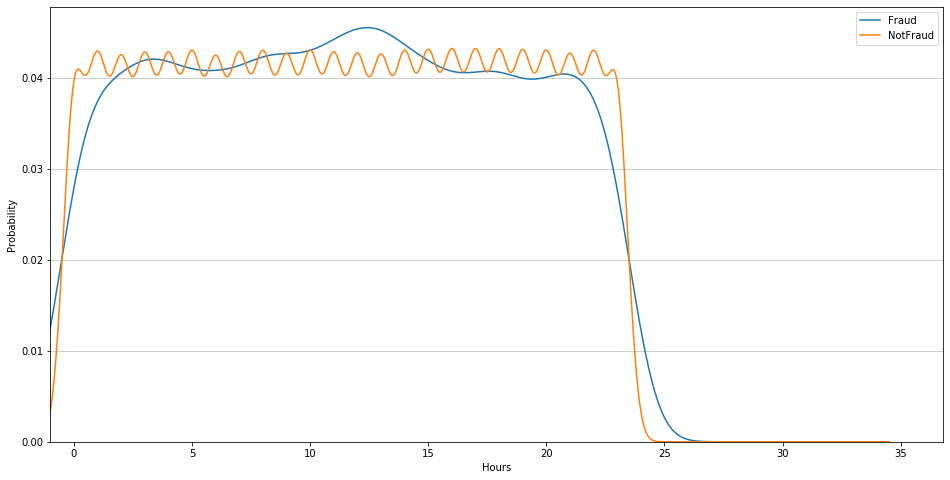

In [168]:
plt.figure(figsize=[16,8]);
#binwidth=1
#a["minute_range"].plot.hist(grid=True,color='r', alpha=0.5, label='x',bins=(range(0,30, binwidth))) # histogram 
ax1=Fraud_transaction["Hour"].plot.kde() #kde plot
ax2=Non_Fraud_transaction["Hour"].plot.kde()
plt.xlim(xmin=-1)
plt.ylim(ymin=0)
plt.xlabel('Hours')
plt.ylabel('Probability')
plt.legend(["Fraud","NotFraud"])
plt.grid(axis='y', alpha=0.75)
plt.show()
#the density plot shows that many of the transactions are below 4 minutes

In [51]:
print("Fraud hour mean :",Fraud_transaction["Hour"].mean())
print("Non Fraud hour mean :",Non_Fraud_transaction["Hour"].mean())
print("Fraud hour median :",Fraud_transaction["Hour"].median())
print("Non Fraud hour median :",Non_Fraud_transaction["Hour"].median())

Fraud hour mean : 11.463960699041637
Non Fraud hour mean : 11.512092574934169
Fraud hour median : 11.0
Non Fraud hour median : 12.0


#### Feature engineering 3 --Rank for transaction_count

In [52]:
#windows function in pandas
transaction['TransactionNumber']=transaction.groupby(by=['customerId'])['transactionDateTime_date'].transform(lambda x:x.rank(method='min'))
transaction['TransactionNumber']=transaction.apply(lambda x:int(x['TransactionNumber']),axis=1)

In [53]:
transaction.head(20)

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,isFraud,transactionDateTime_date,Match,Time_Diff,CvvMatch,Year,Month,Day,Hour,TransactionNumber
541900,100088067,100088067,50000,50000.00,205.13,EZ Putt Putt #982199,US,US,02,01,...,False,2016-01-12 00:59:52,False,NaT,1,2016,1,12,0,1
541901,100088067,100088067,50000,49794.87,46.43,Dinosaur Sandwitch Bar #303701,US,US,05,01,...,False,2016-01-12 19:49:41,False,0 days 18:49:49,1,2016,1,12,19,2
541902,100088067,100088067,50000,49748.44,378.67,Mobile eCards,US,US,05,01,...,False,2016-01-17 15:41:46,False,4 days 19:52:05,1,2016,1,17,15,3
541903,100088067,100088067,50000,50000.00,66.07,EZ Putt Putt #40513,US,US,02,01,...,False,2016-02-02 19:57:18,False,16 days 04:15:32,1,2016,2,2,19,4
541904,100088067,100088067,50000,49933.93,141.60,34th BBQ #412895,US,US,09,08,...,False,2016-02-03 04:48:54,False,0 days 08:51:36,1,2016,2,3,4,5
541905,100088067,100088067,50000,49792.33,259.44,Blue Mountain eCards,US,US,05,01,...,False,2016-02-08 06:09:12,False,5 days 01:20:18,1,2016,2,8,6,6
541906,100088067,100088067,50000,49532.89,32.50,EZ Putt Putt #804489,US,US,09,01,...,False,2016-02-09 18:36:53,False,1 days 12:27:41,1,2016,2,9,18,7
541907,100088067,100088067,50000,49500.39,23.06,South Cafe,US,US,02,01,...,False,2016-02-09 23:44:13,False,0 days 05:07:20,1,2016,2,9,23,8
541908,100088067,100088067,50000,49477.33,56.05,Fresh Flowers,US,US,05,01,...,False,2016-02-13 20:17:41,False,3 days 20:33:28,1,2016,2,13,20,9
541909,100088067,100088067,50000,49421.28,71.35,AMC #724446,US,US,09,01,...,False,2016-02-21 01:14:56,False,7 days 04:57:15,1,2016,2,21,1,10


In [157]:
transaction.head()

,customerId,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Match,transactionDateTime_date,Time_Diff,CvvMatch,Year,Month,Day,Hour,TransactionNumber
0,737265056,5000,5000.0,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,1803,PURCHASE,0.0,False,False,False,False,2016-08-13 14:27:32,NaT,1,2016,8,13,14,1
1,737265056,5000,5000.0,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,767,PURCHASE,0.0,True,False,False,False,2016-10-11 05:05:54,58 days 14:38:22,1,2016,10,11,5,2
2,737265056,5000,5000.0,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,767,PURCHASE,0.0,False,False,False,False,2016-11-08 09:18:39,28 days 04:12:45,1,2016,11,8,9,3
3,737265056,5000,5000.0,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,767,PURCHASE,0.0,False,False,False,True,2016-12-10 02:14:50,31 days 16:56:11,1,2016,12,10,2,4
4,830329091,5000,5000.0,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,3143,PURCHASE,0.0,True,False,False,False,2016-03-24 21:04:46,-261 days +18:49:56,1,2016,3,24,21,1


In [159]:
transaction[transaction['isFraud']==True].head(20)

,customerId,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,Match,transactionDateTime_date,Time_Diff,CvvMatch,Year,Month,Day,Hour,TransactionNumber
694,984504651,50000,8613.80,165.26,Walgreens #860120,US,US,09,08,health,10/2021,2015-07-27,2016-06-25,8332,PURCHASE,41386.20,False,False,True,False,2016-09-08 16:14:40,0 days 10:56:30,1,2016,9,8,16,590
971,114896048,15000,14113.96,298.85,sears.com,US,US,09,01,online_retail,09/2028,2015-12-19,2015-12-19,8915,PURCHASE,886.04,False,False,True,False,2016-01-06 08:05:06,0 days 02:23:24,1,2016,1,6,8,4
1072,114896048,15000,13702.47,406.89,Planet Fitness #136615,US,US,09,01,health,05/2028,2015-12-19,2015-12-19,8915,PURCHASE,1297.53,False,False,True,False,2016-03-07 02:40:54,2 days 10:08:26,1,2016,3,7,2,105
1113,114896048,15000,8943.58,439.31,oldnavy.com,US,US,09,01,online_retail,05/2032,2015-12-19,2015-12-19,8915,PURCHASE,6056.42,False,False,True,False,2016-04-09 15:14:04,0 days 16:38:11,1,2016,4,9,15,146
1321,114896048,15000,5223.03,266.09,sears.com,US,US,09,01,online_retail,05/2028,2015-12-19,2016-06-10,8915,PURCHASE,9776.97,False,False,True,False,2016-08-24 01:24:35,0 days 08:50:30,1,2016,8,24,1,354
1345,114896048,15000,3094.15,195.28,Uber,US,US,02,01,rideshare,12/2027,2015-12-19,2016-06-10,8915,PURCHASE,11905.85,False,False,True,False,2016-09-08 15:51:39,1 days 03:26:04,1,2016,9,8,15,378
1346,114896048,15000,2898.87,241.73,Uber,US,US,09,08,rideshare,10/2020,2015-12-19,2016-06-10,8915,PURCHASE,12101.13,False,False,True,False,2016-09-08 22:19:31,0 days 06:27:52,1,2016,9,8,22,379
1367,114896048,15000,5422.83,104.34,apple.com,US,US,09,99,online_retail,03/2029,2015-12-19,2016-06-10,8915,PURCHASE,9577.17,False,False,True,False,2016-09-20 20:45:01,0 days 02:41:57,1,2016,9,20,20,400
1416,114896048,15000,11866.15,143.07,oldnavy.com,US,US,09,,online_retail,06/2031,2015-12-19,2016-06-10,8915,PURCHASE,3133.85,False,False,True,False,2016-10-24 04:26:33,0 days 11:24:41,1,2016,10,24,4,449
1623,482277829,5000,1482.10,345.45,ebay.com,US,US,02,01,online_retail,07/2029,2014-11-15,2014-11-15,7507,PURCHASE,3517.90,False,False,True,False,2016-12-10 23:43:11,0 days 23:21:17,1,2016,12,10,23,118


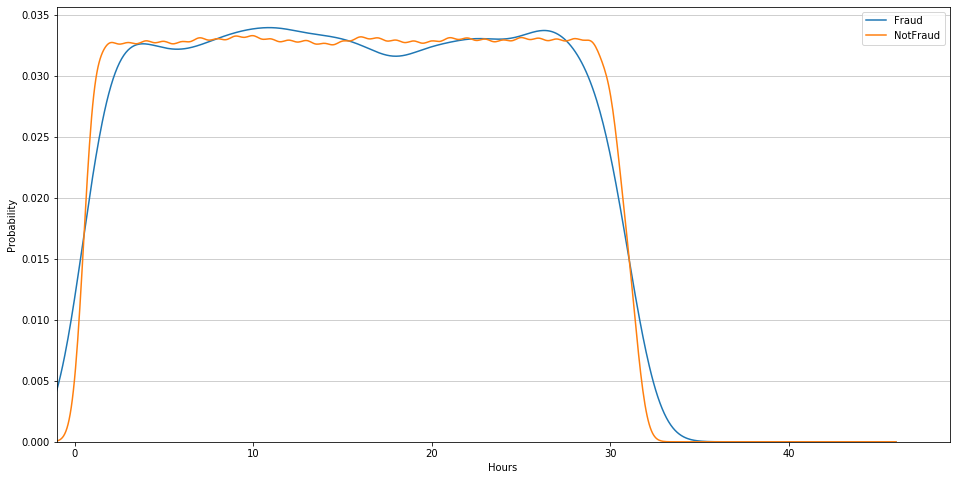

In [169]:
#comparing Day
plt.figure(figsize=[16,8]);
#binwidth=1
#a["minute_range"].plot.hist(grid=True,color='r', alpha=0.5, label='x',bins=(range(0,30, binwidth))) # histogram 
ax1=Fraud_transaction["Day"].plot.kde() #kde plot
ax2=Non_Fraud_transaction["Day"].plot.kde()
plt.xlim(xmin=-1)
plt.ylim(ymin=0)
plt.xlabel('Day')
plt.ylabel('Probability')
plt.legend(["Fraud","NotFraud"])
plt.grid(axis='y', alpha=0.75)
plt.show()
#the density plot shows that many of the transactions are below 4 minutes

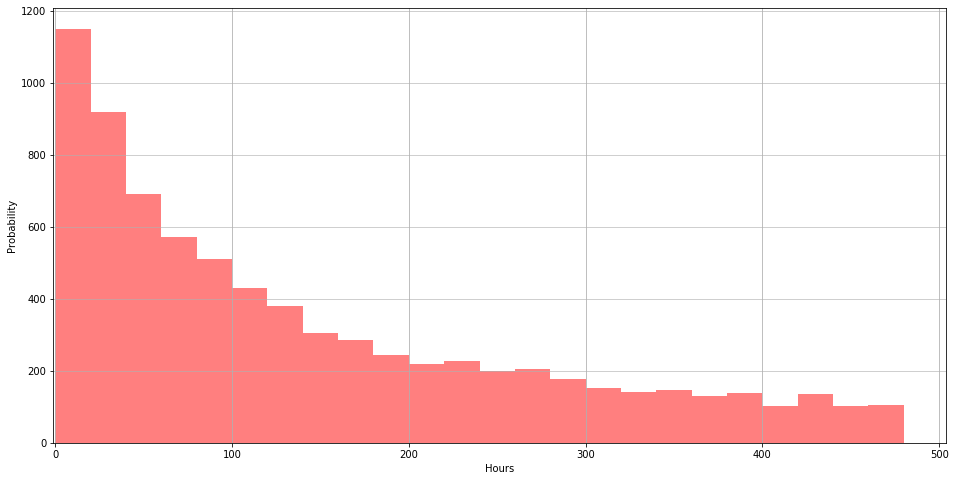

In [178]:
#histogram transaction[transaction['isFraud']==True]
plt.figure(figsize=[16,8]);
binwidth=20
#a["minute_range"].plot.hist(grid=True,color='r', alpha=0.5, label='x',bins=(range(0,30, binwidth))) # histogram 
a["TransactionNumber"].plot.hist(grid=True,color='r', alpha=0.5, label='x',bins=(range(0,500, binwidth))) # histogram
#ax2=Non_Fraud_transaction["Day"].plot.kde()
plt.xlim(xmin=-1)
plt.ylim(ymin=0)
plt.xlabel('Hours')
plt.ylabel('Probability')
#plt.legend(["Fraud","NotFraud"])
plt.grid(axis='y', alpha=0.75)
plt.show()
#the density plot shows that many of the transactions are below 4 minutes

Steps to use in Modelling:
Drop the columns which has all null values
Drop those column which are mostly similar and not adding much information
Replacing the Null values
Feature Engineering: Creating Features which might be important in the model
Label encoding the categorical variable
Splitiing the data into train and test
This is an imbalanced class problem as there are only 1.5% True values in Fraud. We can try some sampling techniques to improve the accuracy of the model
Doing 5 folds of Cross Validation to build the model robust
Metric of evaluation: AUC- ROC score, Recall, F1 score
I'll be mostly using tree based model to do the classification

In [54]:
transaction.drop(columns=['echoBuffer', 'merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'], inplace = True)

In [55]:
# CustomerId and accountNumber are the same 
diff = (transaction['accountNumber']  != transaction['customerId']).sum()
print("No. of different account number and customerid", diff)

No. of different account number and customerid 0


In [56]:
diff = (transaction['acqCountry']  != transaction['merchantCountryCode']).sum()
print("No. of different acqCountry and merchantCountryCodea", diff/transaction.shape[0])

No. of different acqCountry and merchantCountryCodea 0.004973530036382688


In [57]:
transaction.drop(columns= ["accountNumber","acqCountry","availableMoney"], inplace = True, axis = 1)

In [58]:
print("Null Values as empty string")
str_columns = transaction.select_dtypes(include=['object']).columns
for col in str_columns:
    null_value = (transaction[col].values == '').sum()
    print(col,"-",null_value)

Null Values as empty string
merchantName - 0
merchantCountryCode - 724
posEntryMode - 4054
posConditionCode - 409
merchantCategoryCode - 0
currentExpDate - 0
accountOpenDate - 0
dateOfLastAddressChange - 0
transactionType - 698


In [63]:
#date conversion
from datetime import datetime
def date_convertion(x):
    return (x.year,x.month,x.day,x.hour)

def convert_str_to_date(date_var):
    return(datetime.strptime(date_var["transactionDateTime"], '%Y-%m-%dT%H:%M:%S'))

transaction["transactionDateTime_date"]=transaction.apply(convert_str_to_date,axis=1)
transaction['Year'], transaction['Month'], transaction['Day'], transaction['Hour'] = zip(*transaction['transactionDateTime_date'].map(date_convertion))


KeyError: 'transactionDateTime'

In [ ]:
transaction.head()

In [64]:
Fraud_transaction=transaction[transaction['isFraud']==True]
Non_Fraud_transaction=transaction[transaction['isFraud']==False]

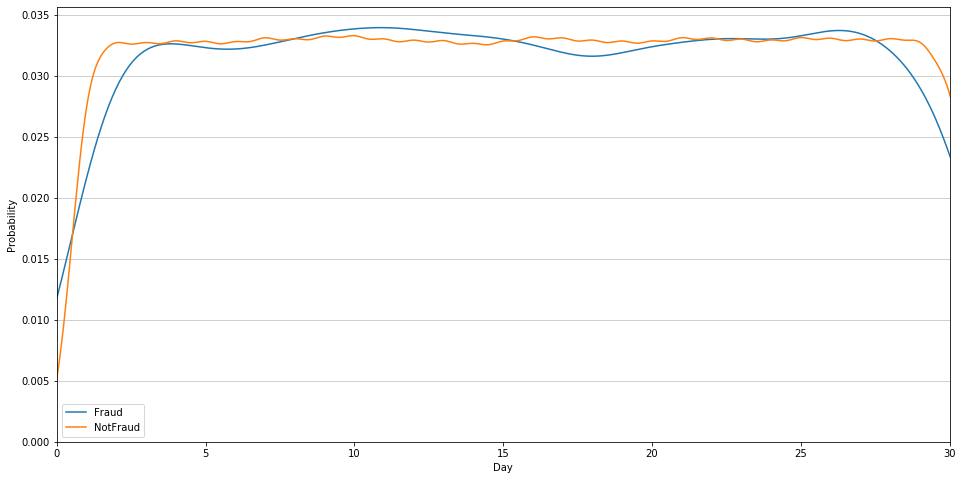

In [76]:
#comparing Day
plt.figure(figsize=[16,8]);
ax1=Fraud_transaction["Day"].plot.kde() #kde plot
ax2=Non_Fraud_transaction["Day"].plot.kde()
plt.xlim(xmin=0)
plt.xlim(xmax=30)
plt.ylim(ymin=0)
plt.xlabel('Day')
plt.ylabel('Probability')
plt.legend(["Fraud","NotFraud"])
plt.grid(axis='y', alpha=0.75)
plt.show()

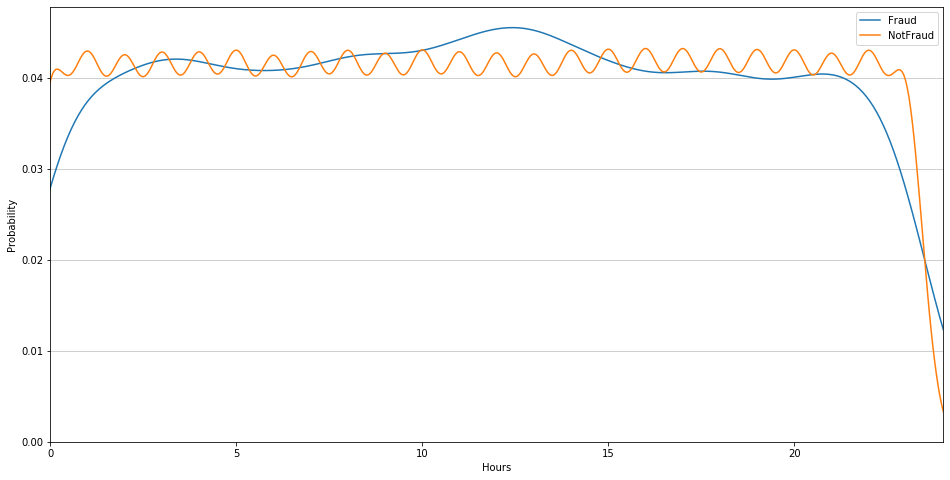

In [77]:
plt.figure(figsize=[16,8]); 
ax1=Fraud_transaction["Hour"].plot.kde() #kde plot
ax2=Non_Fraud_transaction["Hour"].plot.kde()
plt.xlim(xmin=0)
plt.xlim(xmax=24)
plt.ylim(ymin=0)
plt.xlabel('Hours')
plt.ylabel('Probability')
plt.legend(["Fraud","NotFraud"])
plt.grid(axis='y', alpha=0.75)
plt.show()

In [65]:
#windows function in pandas
transaction['TransactionNumber']=transaction.groupby(by=['customerId'])['transactionDateTime_date'].transform(lambda x:x.rank(method='min'))
transaction['TransactionNumber']=transaction.apply(lambda x:int(x['TransactionNumber']),axis=1)

In [66]:
transaction[transaction['customerId'] == 830329091]

,customerId,creditLimit,transactionAmount,merchantName,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,...,isFraud,transactionDateTime_date,Match,Time_Diff,CvvMatch,Year,Month,Day,Hour,TransactionNumber
4,830329091,5000,71.18,Tim Hortons #947751,US,02,01,fastfood,10/2029,2015-08-06,...,False,2016-03-24 21:04:46,False,-281 days +00:58:29,1,2016,3,24,21,1
5,830329091,5000,30.76,In-N-Out #422833,US,02,01,fastfood,01/2020,2015-08-06,...,False,2016-04-19 16:24:27,False,25 days 19:19:41,1,2016,4,19,16,2
6,830329091,5000,57.28,Krispy Kreme #685312,US,02,01,fastfood,05/2020,2015-08-06,...,False,2016-05-21 14:50:35,False,31 days 22:26:08,1,2016,5,21,14,3
7,830329091,5000,9.37,Shake Shack #968081,US,05,01,fastfood,01/2021,2015-08-06,...,False,2016-06-03 00:31:21,False,12 days 09:40:46,1,2016,6,3,0,4
8,830329091,5000,523.67,Burger King #486122,US,02,01,fastfood,08/2032,2015-08-06,...,False,2016-06-10 01:21:46,False,7 days 00:50:25,1,2016,6,10,1,5
9,830329091,5000,164.37,Five Guys #510989,US,05,08,fastfood,04/2020,2015-08-06,...,False,2016-07-11 10:47:16,False,31 days 09:25:30,1,2016,7,11,10,6
10,830329091,5000,160.18,Auntie Anne's #747964,US,02,08,fastfood,05/2023,2015-08-06,...,False,2016-09-07 20:22:47,False,58 days 09:35:31,1,2016,9,7,20,7
11,830329091,5000,40.75,GreenCook,US,09,01,food_delivery,08/2024,2015-08-06,...,False,2016-12-07 16:34:04,False,90 days 20:11:17,1,2016,12,7,16,8
12,830329091,5000,40.75,GreenCook,US,09,01,food_delivery,08/2024,2015-08-06,...,False,2016-12-14 10:00:35,True,6 days 17:26:31,1,2016,12,14,10,9
13,830329091,5000,40.75,GreenCook,US,09,01,food_delivery,08/2024,2015-08-06,...,False,2016-12-20 18:38:23,True,6 days 08:37:48,1,2016,12,20,18,10


In [67]:
#differnet entered cvv and card cvv category 
transaction['CvvMatch']=transaction.apply(lambda x:0 if x['cardCVV']==x['enteredCVV'] else 1,axis=1)
#transaction_copy.drop(columns=['cardCVV','enteredCVV'],axis=1,inplace=True)

KeyError: 'cardCVV'

In [ ]:
transaction.groupby(['CvvMatch','isFraud'])['customerId'].count()

In [ ]:
## We can drop one of the columns as most of them are same
transaction.drop(columns = 'cardCVV', inplace = True, axis = 1)

# droping the date columns
transaction.drop(columns= ['transactionDateTime', 'transactionDateTime_date'], inplace = True, axis = 1)

In [ ]:
transaction['cardLast4Digits'] = transaction['cardLast4Digits'].apply(str)
transaction['len_4_digits'] = transaction['cardLast4Digits'].str.len()


In [ ]:
transaction['Last_addres_diff_open_address'] = transaction.apply(lambda x:0 if x['accountOpenDate']==x['dateOfLastAddressChange'] else 1,axis=1)
len(transaction[transaction['Last_addres_diff_open_address']==1])

In [ ]:
#string format
from datetime import datetime

#convert string to date 
def convert_str_to_date(date_var):
    return(datetime.strptime(date_var["currentExpDate"], '%m/%Y'))

def date_convertion_expiry(x):
    return (x.year,x.month)


transaction["currentExpDateFormat"]=transaction.apply(convert_str_to_date,axis=1)
transaction['Year_expiry_card'], transaction['Month_expiry_card'] = zip(*transaction['currentExpDateFormat'].map(date_convertion_expiry))
transaction.drop(['currentExpDateFormat','currentExpDate', 'accountOpenDate','dateOfLastAddressChange'], inplace = True, axis = 1)

In [ ]:
transaction.groupby(['Last_addres_diff_open_address','isFraud'])['customerId'].count()

In [ ]:
cat_columns_list = ["merchantName", "merchantCountryCode", "posEntryMode", "posConditionCode", "merchantCategoryCode","transactionType", "cardLast4Digits"]
for var in cat_columns_list:
    lb = LabelEncoder()
    lb.fit_transform(transaction[var]) 
transaction.head()

In [ ]:
temp = lb.fit_transform(transaction['cardLast4Digits'])
transaction['cardLast4Digits'] = lb.transform(np.array(transaction['cardLast4Digits']).astype('str'))

In [ ]:
transaction.head()

In [ ]:
bool_columns = transaction.select_dtypes(include=['bool']).columns
#bool_columns
for var in bool_columns:
    transaction[var]=transaction[var].astype(int)
    #transaction[var] = transaction[var].astype(int)

In [ ]:
transaction.drop(columns=['Match','Time_Diff'],inplace=True)

In [ ]:
transaction.dtypes

In [ ]:
predictors = ['creditLimit', 'transactionAmount', 'merchantName','merchantCountryCode', 'posEntryMode', 
              'posConditionCode','merchantCategoryCode', 'enteredCVV','cardLast4Digits','transactionType', 
              'currentBalance', 'cardPresent','expirationDateKeyInMatch', 'Year','Month','Day','Hour','TransactionNumber',
              'CvvMatch','len_4_digits','Last_addres_diff_open_address','Year_expiry_card','Month_expiry_card']

In [62]:
xtrain, xtest, ytrain, ytest = train_test_split(transaction[predictors],transaction['isFraud'], 
                                                  stratify=transaction['isFraud'], 
                                                  random_state=42, 
                                                  test_size=0.15, shuffle=True)

NameError: name 'predictors' is not defined

In [61]:
ytrain.value_counts()

NameError: name 'ytrain' is not defined

In [111]:
NUMBER_KFOLDS = 5
RANDOM_STATE = 2018
VERBOSE_EVAL = 50
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 

In [114]:
!pip install lightgbm

In [173]:
import lightgbm
from lightgbm import LGBMClassifier
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)

# Create arrays and dataframes to store results
oof_preds = np.zeros(xtrain.shape[0])
test_preds = np.zeros(xtest.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0
for train_idx, valid_idx in kf.split(xtrain):
    train_x, train_y = xtrain[predictors].iloc[train_idx],ytrain.iloc[train_idx]
    valid_x, valid_y = xtrain[predictors].iloc[valid_idx],ytrain.iloc[valid_idx]
    
    
    
    
    evals_results = {}
    model =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)
    
    model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', verbose= VERBOSE_EVAL, early_stopping_rounds= EARLY_STOP)
    
    
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(xtest[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
    if n_fold!=4:
        del model, train_x, train_y, valid_x, valid_y
        gc.collect()
    n_fold = n_fold + 1
        

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=-1 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.767343	valid_1's auc: 0.769053
[100]	training's auc: 0.778897	valid_1's auc: 0.779841
[150]	training's auc: 0.788015	valid_1's auc: 0.787074
[200]	training's auc: 0.795808	valid_1's auc: 0.792731
[250]	training's auc: 0.804064	valid_1's auc: 0.798751
[300]	training's auc: 0.810977	valid_1's auc: 0.802925
[350]	training's auc: 0.817743	valid_1's auc: 0.807129
[400]	training's auc: 0.823276	valid_1's auc: 0.810037
[450]	training's auc: 0.828394	valid_1's auc: 0.812311
[500]	training's auc: 0.832601	valid_1's auc: 0.813724
[550]	training's auc: 0.837162	valid_1's auc: 0.815646
[600]	training's auc: 0.841094	valid_1's auc: 0.816923
[650]	training's auc: 0.845151	valid_1's auc: 0.818473
[700]	training's auc: 0.848632	valid_1's auc: 0.819237
[750]	training's auc: 0.851915	valid_1's auc: 0.819833
[

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.773357	valid_1's auc: 0.752104
[100]	training's auc: 0.785518	valid_1's auc: 0.759103
[150]	training's auc: 0.795523	valid_1's auc: 0.764332
[200]	training's auc: 0.80376	valid_1's auc: 0.7698
[250]	training's auc: 0.81155	valid_1's auc: 0.774509
[300]	training's auc: 0.818091	valid_1's auc: 0.778466
[350]	training's auc: 0.824459	valid_1's auc: 0.782142
[400]	training's auc: 0.830127	valid_1's auc: 0.784747
[450]	training's auc: 0.834989	valid_1's auc: 0.786681
[500]	training's auc: 0.839423	valid_1's auc: 0.78855
[550]	training's auc: 0.843705	valid_1's auc: 0.79033
[600]	training's auc: 0.847287	valid_1's auc: 0.791607
[650]	training's auc: 0.850642	valid_1's auc: 0.792784
[700]	training's auc: 0.854043	valid_1's auc: 0.794123
[750]	training's auc: 0.856967	valid_1's auc: 0.795016
[800]	training's auc: 0.859999	valid_1's auc: 0.79542
[850]	training's auc: 0.862781	valid_1's auc: 0.796015
[900]	traini

In [174]:
preds = model.predict(valid_df[predictors])

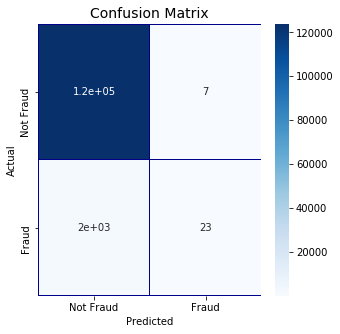

In [175]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [176]:
roc_auc_score(valid_df[target].values, preds)

0.5057246093709677

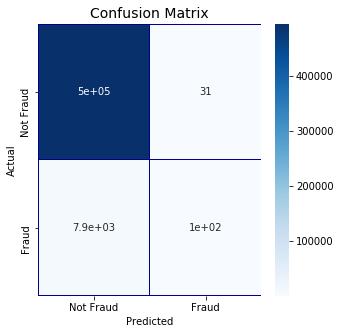

0.5064989085885835

In [177]:
preds = model.predict(train_df[predictors])
cm = pd.crosstab(train_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()
roc_auc_score(train_df[target].values, preds)

In [154]:
#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

In [69]:
import lightgbm
from lightgbm import LGBMClassifier
clf =  LGBMClassifier(
                  nthread=-1,
                  n_estimators=2000,
                  learning_rate=0.01,
                  num_leaves=80,
                  colsample_bytree=0.98,
                  subsample=0.78,
                  reg_alpha=0.04,
                  reg_lambda=0.073,
                  subsample_for_bin=50,
                  boosting_type='gbdt',
                  is_unbalance=False,
                  min_split_gain=0.025,
                  min_child_weight=40,
                  min_child_samples=510,
                  objective='binary',
                  metric='auc',
                  silent=-1,
                  verbose=-1,
                  feval=None)

In [155]:
train_df, test_df = train_test_split(transaction, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [122]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [164]:
#!pip install RandomForestClassifier
#import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  AdaBoostClassifier

In [70]:
target='isFraud'
clf.fit(train_df[predictors], train_df[target].values)

NameError: name 'train_df' is not defined

In [158]:
preds = clf.predict(valid_df[predictors])

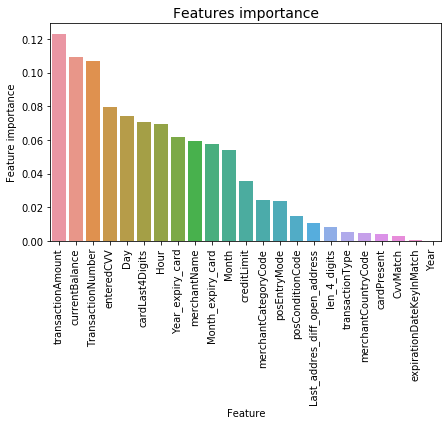

In [159]:
import seaborn as sns
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

In [160]:
roc_auc_score(valid_df[target].values, preds)

0.5102510894113174

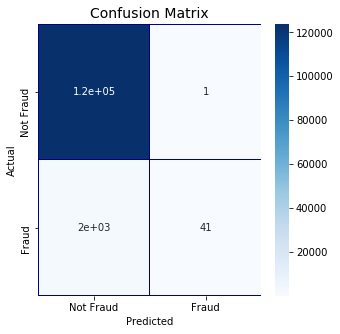

In [162]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [165]:
#AdaBoost
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [166]:
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=100, random_state=2018)

In [167]:
preds = clf.predict(valid_df[predictors])

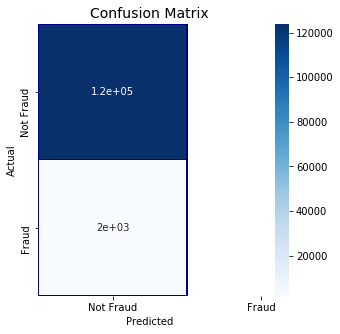

In [168]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show() 

In [169]:
roc_auc_score(valid_df[target].values, preds)

0.5